In [1]:
import os, cv2, random
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img
from keras import layers, models, optimizers
from keras import backend as K
from sklearn.model_selection import train_test_split
from matplotlib import pyplot

Using TensorFlow backend.


# Cats vs Dogs

Esta base de datos se tomó de kaggle. Está partido en dos carpetas, una de testeo (12.5k,  272 MBs) y otra de entrenamiento (25k, 545 MBs). El objetivo del ejercicio va a ser construir un clasificacdor que diferencie entre **Perros y Gatos**. <br> Los datos están como imágenes, entonces el primer paso es cargar estos y obtener su información en RGB. Hay dos retos al momento de tratar con estas imágenes:
- Hay demasiadas imágenes, lo que hace el entrenamiento del modelo lento
- Su tamaño es heterogéneo, por ejemplo, hay imágenes de 500x374 y otras de 312x396. <br><br>
Para resolver lo anterior es necesario hacer un muestreo, asegurandose que quede balanceada la muestra, y se debe homogeneizar el tamaño de las imágenes.

In [2]:
## Tamaño de imágenes 
img_width = 150
img_height = 150

## La ruta donde están las imágenes
TRAIN_DIR = './data/cats vs dogs/train/'
TEST_DIR = './data/cats vs dogs/test1/'

## Construyo listas con los directorios completos incluyendo el nombre de los archivos de las imágenes
train_images_dogs_cats = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)] # use this for full dataset
test_images_dogs_cats = [TEST_DIR+i for i in os.listdir(TEST_DIR)]

In [3]:
## Se aleatoriza la selección de las imágenes
n=5000 #---> Tamaño de muestra con las que se va a trabajar
indice=random.sample(range(1,len(train_images_dogs_cats)), n)
nombres_entrenamiento=[train_images_dogs_cats[i] for i in indice]

### Marcación
La marcación se encuentra en el nombre de los archivos. A continuación se construye una función que extraiga si es gato o perro la imágen. (e.g *./data/cats vs dogs/train/cat.1715.jpg* es la ruta a la imágen de una gato). Se le va a asignar un __1__ a los perros y **0** a los gatos

In [4]:
def marcacion(text):
    if text.find('dog.')!=-1:
        label=1
    elif text.find('cat.')!=-1:
        label=0
    else: ## Este es en caso que haya una imágen con un nobre de formato distinto, sería necesario estudiar su caso
        label=-1
    return label

In [5]:
## Aplico la marcación a toda la muestra aleatoria y estudio el balanceo
labels=np.array([marcacion(x) for x in nombres_entrenamiento])

print('Hay {} perros y {} gatos, es decir un desbalance de {}%'.format(sum(labels),len(labels)-sum(labels),sum(labels)/len(labels)))

Hay 2552 perros y 2448 gatos, es decir un desbalance de 0.5104%


## Carga de imágenes
Para cargar y reescalar las las imágenes se utiliza el paquete _openCV_. El paquete anterior se intala en el prompt de Anaconda con el comando _pip install opencv-python_, para cargar el paquete en python es com _import cv2_. Para lograr el objetivo definimos una función que tome la lista de las rutas de las imágenes y las cargue reescaladas

In [6]:
def preparar_imagenes(lista_archivos, ancho=100, alto=100):
    
    x=[]
    for image in lista_archivos:
        x.append(cv2.resize(cv2.imread(image), (ancho, alto), interpolation=cv2.INTER_CUBIC))
    return np.array(x)

In [7]:
%%time
## Aplico la función a la submuestra seleccionada. Para 2500 imágenes tomó alrededor de 42 segundos.
X=preparar_imagenes(nombres_entrenamiento, img_width, img_height)

Wall time: 48.2 s


In [8]:
print(K.image_data_format()) 
print('Que sea channels_last significa que keras espera en la primera capa un input_shape de (ancho, alto, 3).',
     'Entonces el input_shape de la red es una tupla de tres dimensiones donde la tercera dimensión representa la entrada RGB')

channels_last
Que sea channels_last significa que keras espera en la primera capa un input_shape de (ancho, alto, 3). Entonces el input_shape de la red es una tupla de tres dimensiones donde la tercera dimensión representa la entrada RGB


## Exploración y Visualización de una imagen

In [9]:
print('Las dimensiones del objeto que contiene las imágenes es de: {}'.format(np.array(X).shape))
print('Note que el tamaño del objeto representa {} imágenes, {}  pixeles de ancho,'.format(np.array(X).shape[0],np.array(X).shape[1]),
      '{} pixeles de alto y {} dimensiones de representación (RGB)'.format(np.array(X).shape[2],np.array(X).shape[3]))

Las dimensiones del objeto que contiene las imágenes es de: (5000, 150, 150, 3)
Note que el tamaño del objeto representa 5000 imágenes, 150  pixeles de ancho, 150 pixeles de alto y 3 dimensiones de representación (RGB)


In [13]:
aleatorio=random.randint(a=1, b=len(X))
print('Los primeros dos pixeles de una imagen aleatorio se ven de la siguiente manera: \n {}'.format(X[aleatorio,0:2,0:2]))

Los primeros dos pixeles de una imagen aleatorio se ven de la siguiente manera: 
 [[[89 51 87]
  [73 41 82]]

 [[74 40 80]
  [70 38 82]]]


#### Para visualizar una imagen se utiliza submodulo _pyplot_ de _matplotlib_. De aquí se llama la función imshow() la cual recibe los pixeles en RGB y grafica la imagen. A continuación se grafican los primero dos pixeles de la primera imagen anteriormente estudiada y la imagen completa


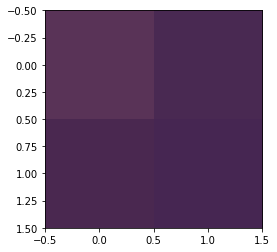

In [14]:
pyplot.imshow(X[aleatorio,0:2,0:2])

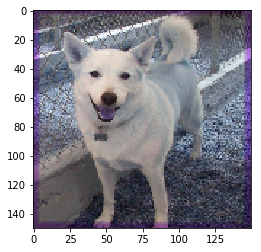

In [15]:
pyplot.imshow(X[aleatorio])

## Se separa la muestra en Entrenamiento y Validación (70/30)

In [16]:
X_train, X_val, Y_train, Y_val = train_test_split(X, labels, test_size=0.3, random_state=666, )
n_train=X_train.shape[0]
n_val=X_val.shape[0]

In [17]:
print('Hay {} imágenes en el entrenamiento y {} en la base de validación.\n'.format(n_train, n_val),
     'En el entrenamiento el {}% son perros. \n'.format(sum(Y_train)/n_train),
     'En la base de validación el {}% son perros'.format(sum(Y_val)/n_val))

Hay 3500 imágenes en el entrenamiento y 1500 en la base de validación.
 En el entrenamiento el 0.512% son perros. 
 En la base de validación el 0.5066666666666667% son perros


# Modelo
1. Construir la arquitectura (definir el modelo)
2. Compilar el modelo (definir función de pérdida y el optimizador)
3. Alteración de fotos (image augmentation)
4. Entrenamiento y Validación
5. Testeo


## 1. Construir la arquitectura (definir el modelo)

In [19]:
model = models.Sequential()

model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), input_shape=(img_width, img_height, 3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(filters=64, kernel_size=(3, 3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(filters=64, kernel_size=(3, 3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(filters=128, kernel_size=(3, 3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(filters=256, kernel_size=(3, 3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))


model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
##model.add(layers.Activation('relu'))
model.add(layers.Dense(1, activation='sigmoid'))
##model.add(layers.Activation('sigmoid'))

## 2. Compilar el modelo (definir función de pérdida y el optimizador)

In [20]:
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy']) 

In [21]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 72, 72, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 64)        36928     
__________

# 3. Alteración de fotos (image augmentation)

In [22]:
## Construyo lo objetos que van a generar alteraciones en la base de entrenamiento y validación
# La función ImageDataGenerator es de keras
train_datagen = ImageDataGenerator(
    rescale=1. / 255, ## Reescalar las imágenes construidas por este generador
    shear_range=0.2, ## Grados de rotation en sentido del reloj
    zoom_range=0.2, ## Rango de zoom aleatorio [1-0.2,1+0.2]
    horizontal_flip=True) ## Voltear la imagen de manera horizontal

val_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

In [23]:
%%time
## El método .flow() toma las imágenes (los pixeles RGB) y la marcación y crea nuevas imágenes degeneradas de las originales.
train_generator = train_datagen.flow(np.array(X_train), Y_train, batch_size=16)
validation_generator = val_datagen.flow(np.array(X_val), Y_val, batch_size=16)

Wall time: 1.26 s


# 4. Entrenamiento y Validación

In [24]:
from keras.callbacks import TensorBoard
from time import time
tensorboard = TensorBoard(log_dir='logs/{}'.format(time()))

In [21]:
%%time
batch_size=16
history = model.fit_generator(
    train_generator, 
    #steps_per_epoch=n_train // batch_size,
    epochs=60,
    validation_data=validation_generator,
    #validation_steps=n_val // batch_size,
    callbacks=[tensorboard], initial_epoch=0
)

Epoch 1/60
219/219 [==============================] - 23s 105ms/step - loss: 0.6970 - acc: 0.5354 - val_loss: 0.6895 - val_acc: 0.5467
Epoch 2/60
219/219 [==============================] - 24s 109ms/step - loss: 0.6820 - acc: 0.5874 - val_loss: 0.6341 - val_acc: 0.6407
Epoch 3/60
219/219 [==============================] - 21s 98ms/step - loss: 0.6492 - acc: 0.6275 - val_loss: 0.6431 - val_acc: 0.6427
Epoch 4/60
219/219 [==============================] - 30s 135ms/step - loss: 0.6120 - acc: 0.6665 - val_loss: 0.6044 - val_acc: 0.6653
Epoch 5/60
219/219 [==============================] - 22s 102ms/step - loss: 0.5976 - acc: 0.6840 - val_loss: 0.5961 - val_acc: 0.6740
Epoch 6/60
219/219 [==============================] - 21s 98ms/step - loss: 0.5699 - acc: 0.7141 - val_loss: 0.5751 - val_acc: 0.7153
Epoch 7/60
219/219 [==============================] - 25s 115ms/step - loss: 0.5576 - acc: 0.7201 - val_loss: 0.5598 - val_acc: 0.7267
Epoch 8/60
219/219 [==============================] - 29s

In [22]:
prob_train=model.predict_proba(X_train)
prob_val=model.predict_proba(X_val)

In [23]:
from sklearn.metrics import roc_auc_score
print('La AUC ROC de entrenamiento fue {}'.format(roc_auc_score(Y_train, prob_train)))
print('La AUC ROC de validación fue {}'.format(roc_auc_score(Y_val, prob_val)))

La AUC ROC de entrenamiento fue 0.9091625197133497
La AUC ROC de validación fue 0.8436552034572883


In [24]:
data=pd.DataFrame(np.column_stack([Y_val, prob_val]), columns=['Y_val', 'pro_val'])
data.to_pickle('predicciones.pkl', 'gzip')
np.save('X_val', X_val)

In [25]:
data=pd.read_pickle('predicciones.pkl', 'gzip')
Y_val=np.array(data.Y_val)
prob_val=np.array(data.pro_val)
X_val=np.load('X_val.npy')

Esta marcado como un 0.0 y fue predicho como 0.0014063790440559387


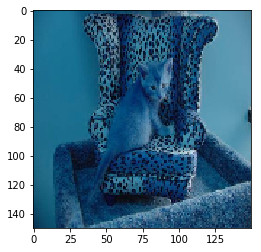

In [28]:
posicion=random.randint(a=1, b=len(X_val))

pyplot.imshow(X_val[posicion])
print('Esta marcado como un {} y fue predicho como {}'.format(Y_val[posicion], model.predict(X_val[posicion].reshape((1,150,150,3)))[0][0]))

Esta marcado como un 0.0 y fue predicho como 1


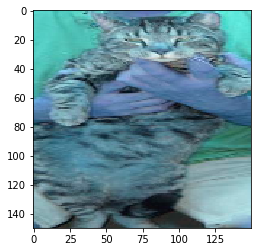

In [30]:
errores_bool=(prob_val>0.5)!=Y_val
err_pos=[]
for i in range(len(errores_bool)):
    if errores_bool[i]:
        err_pos.append(i)

posicion=random.randint(a=1, b=len(err_pos))
rand=err_pos[posicion]
pyplot.imshow(X_val[rand])
print('Esta marcado como un {} y fue predicho como {}'.format(Y_val[rand], (prob_val[rand]>0.5).astype(int)))

In [28]:
pd.crosstab(Y_val, (prob_val>0.5).astype(float))

col_0,0.0,1.0
row_0,,
0.0,560,211
1.0,32,697


In [29]:
pd.crosstab(Y_train, (prob_train[:,0]>0.5).astype(float))

col_0,0.0,1.0
row_0,,
0,1486,319
1,14,1681


In [30]:
accuracy=(1-sum(errores_bool)/len(errores_bool))*100
print('Accuracy: {}'.format(accuracy))

Accuracy: 83.8
